# Hyperparameter combinations

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric = 'auc_relaxed'

dataset = 'kws'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [41]:
import itertools

files_auc = [
    f'{base_path}/{metric}_SHAP_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
]


ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'noise']
methods = ['SHAP', 'LR', 'RF']
dfs = []
for method, file_template in zip(methods, files_auc):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()

In [42]:
files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_LR_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_RF_{{}}_{intersection}.tsv',
]

names = ["zeros", 'noise']
methods = ['SHAP', 'LR', 'RF']

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [43]:
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

Index(['0.2_1', '0.2_3', '0.2_5', '0.3_1', '0.3_3', '0.3_5', '0.4_1', '0.4_3',
       '0.4_5', 'pooled'],
      dtype='object')
Index(['0.2_1', '0.2_3', '0.2_5', '0.3_1', '0.3_3', '0.3_5', '0.4_1', '0.4_3',
       '0.4_5', 'pooled'],
      dtype='object')


/tmp/ipykernel_779797/506563099.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notna(x) else "").values
/tmp/ipykernel_779797/506563099.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notna(x) else "").values


Index(['0.2_1', '0.2_3', '0.2_5', '0.3_1', '0.3_3', '0.3_5', '0.4_1', '0.4_3',
       '0.4_5', 'pooled'],
      dtype='object')


/tmp/ipykernel_779797/506563099.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notna(x) else "").values


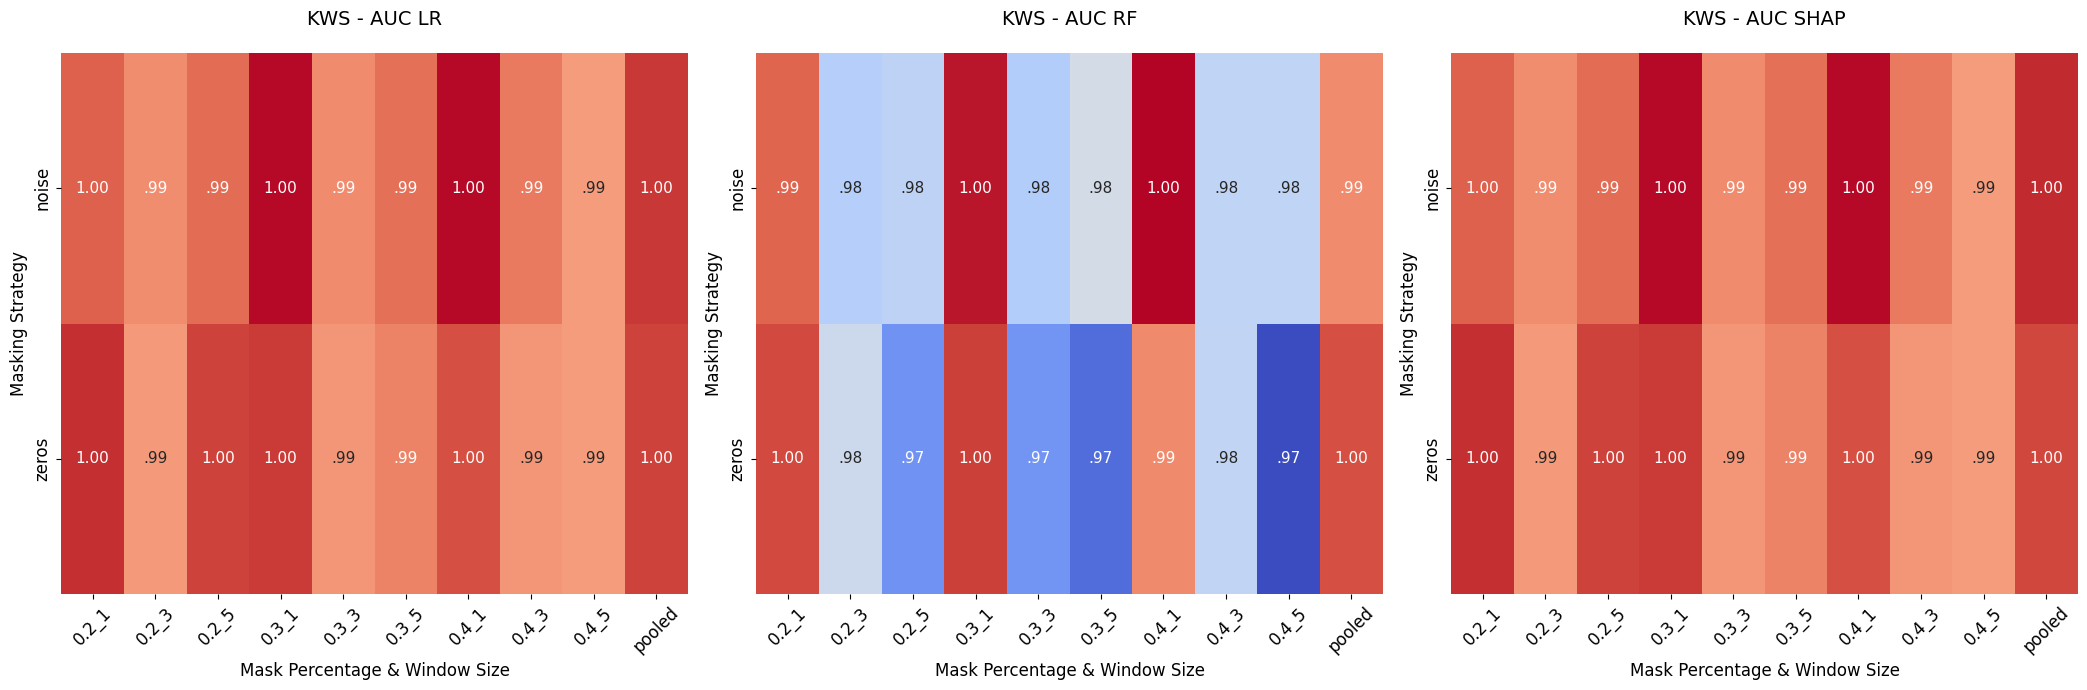

In [44]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df[value].max()
min_auc = mean_auc_df[value].min()

methods = mean_auc_df['method'].unique()
n_methods = len(methods)
n_cols = 3  
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 7 * n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values=value
    )

    # Flatten the MultiIndex of columns if needed
    pivot_table.columns = [f'{x[0]}_{x[1]}' for x in pivot_table.columns]

    # Get annotation values and create the 'pooled' column
    annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]
    row_labels = pivot_table.index
    pooled_col = [annotations.get(label, "") for label in row_labels]  # Replace None with empty string

    # Add 'pooled' as another regular column (not part of the index)
    pivot_table['pooled'] = pooled_col

    # Create annotation formatting (use map to format annotations correctly)
    annot = pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0') if pd.notna(x) else "").values

    # Plot heatmap
    sns.heatmap(
        pivot_table,  # Include 'pooled' in the pivot table
        annot=annot,
        cmap="coolwarm",
        fmt="",
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods),
        annot_kws={'size': ANNOT_SIZE}
    )

    ax.set_title(f'KWS - AUC {method}', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Mask Percentage & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Masking Strategy', fontsize=LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [48]:
import ast
from utils import clean_and_eval, perc_segments_gt

metric = 'score_curve'
methods = ['SHAP', 'LR', 'RF']

base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}.tsv',
    f'{base_path}/{metric}_LR_{{}}.tsv',
    f'{base_path}/{metric}_RF_{{}}.tsv',
]

names=['zeros', 'noise']
metric = 'score_curve'

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            if dataset == "drums":
                df_combination['log_odds'] = df_combination['actual_score'].apply(clean_and_eval)
            else:
                df_combination['log_odds'] = df_combination['actual_score'].apply(ast.literal_eval)

            df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
            df_combination['event_label'] = df_combination['event_label'].apply(int)
            percentages = [0.01, 0.05, 0.1, 0.2, 0.5, 'adapt']
            for i in percentages:
                if i == 'adapt':
                    df_combination[f'top_{i}'] = df_combination.apply(
                        lambda row: row['log_odds'][row['event_label']] - 
                                    row['log_odds_curve'][int(len(row['log_odds_curve']) * 
                                    (perc_segments_gt(row['filename'], row['event_label'], dataset) / 100))][row['event_label']],
                        axis=1
                    )

                else:
                    df_combination[f'top_{i}'] = df_combination.apply(
                        lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['log_odds_curve']) * i)][row['event_label']],
                        axis=1
                    )

        except FileNotFoundError:
            print(f"File not found: {file_path}")

        df_combinations.append(df_combination)
            
final_df_combination_ff = pd.concat(df_combinations, ignore_index=True)

In [49]:
mean_auc_df_combination_ff = final_df_combination_ff.groupby(['method', 'name'])[['top_0.01', 'top_0.05', 'top_0.1', 'top_0.2', 'top_0.5', 'top_adapt']].mean().reset_index()
mean_auc_df_combination_ff

,method,name,top_0.01,top_0.05,top_0.1,top_0.2,top_0.5,top_adapt
0,LR,noise,0.396189,1.499125,2.615413,4.357010,6.451707,4.002707
1,LR,zeros,0.363784,1.015252,2.170822,4.065832,6.847117,3.956992
2,RF,noise,0.343631,1.412428,2.352517,3.550037,5.742727,3.507661
3,RF,zeros,0.284399,0.848730,1.707658,3.216492,5.706557,3.118198
4,SHAP,noise,0.425822,1.393339,2.336209,3.418822,5.197474,3.187495
5,SHAP,zeros,0.439270,1.161824,1.921296,3.227843,5.871227,3.461499


In [51]:
from scipy.stats import pearsonr

corr1, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.01'])
corr5, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.05'])
corr10, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.1'])
corr20, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.2'])
corr50, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_0.5'])
corradapt, _ = pearsonr(mean_auc_df_combination['roc_auc'], mean_auc_df_combination_ff['top_adapt'])

print(f'Correlation for dataset {dataset}')
print(f'Correlation 1% {corr1}')
print(f'Correlation 5% {corr5}')
print(f'Correlation 10% {corr10}')
print(f'Correlation 20% {corr20}')
print(f'Correlation 50% {corr50}')
print(f'Correlation adapt% {corradapt}')

Correlation for dataset audioset_dog
Correlation 1% -0.9168953148726562
Correlation 5% -0.29967523009191877
Correlation 10% -0.2931036042104862
Correlation 20% -0.21784133625957258
Correlation 50% -0.12584283180465508
Correlation adapt% -0.2940514189956678


## Prepare videos

In here we will create a video to look at the result, we need to select the instances to plot. In this case, we decided to filter by FF 20% as its the number that correlates more. And in that case 

In [69]:
final_df_combination_ff['filename'].tolist()


['8qMwRaqKt3Y',
 'vyYpxGJr7zI',
 'QejVyYvjrrs',
 'AW3s9S3xEQ0',
 'wYNKH0Ou9vM',
 'qpNx57h9Ngw',
 'ojLv2Ji6cJQ',
 '20qZLse0acs',
 'mOlWsXoDXsY',
 'd2yLX6TwS_c',
 'bDpowdWB7lk',
 'y046Ewwm1Ng',
 '_fTONy_pqik',
 'yoRAvKxwq2U',
 'oSME-ts1WnQ',
 'SUFOgc9Pkd8',
 'IsKPMBn6irE',
 '0Wkk9iNzA9c',
 '5lw-BHt_rXY',
 'tSX2jYLgPng',
 '3LvZUtupOCs',
 '1_Q80fDGLRM',
 '4Jc8UZHaqHw',
 '8vasA2D2_Kc',
 '3IdazIWh2Ew',
 'gCHF0oBPZv8',
 'aNkOcOCm32s',
 'LtFHLdluyzM',
 '--4gqARaEJE',
 'JQwirnKysXI',
 'cHw4f9925NA',
 'EeGWe8e_2jg',
 'f1Z-HuZ-_ZA',
 'k3AYfr6PIgs',
 'AF0CtMb81t8',
 'qAtX6QRLKy0',
 '6SXBknR8MH4',
 '6GjsjhAbXRo',
 'UWizNEHrzCY',
 'N6e5C5sXdBI',
 'hoD3P2WyziY',
 '9TzyRdTYDvo',
 '6kUtpAr79xU',
 '2tBRn4xKmzM',
 'v5IM8bUpeP8',
 '3qesirWAGt4',
 'DpLi9YH5idY',
 'nzqXNoDHdc8',
 'tSX2jYLgPng',
 'vyYpxGJr7zI',
 '3qesirWAGt4',
 'nzqXNoDHdc8',
 'bA8idGxNUkQ',
 'JErx-AImWqk',
 'M4blyCNxeBQ',
 'ZyiDGq0qh2s',
 'IBGfcPIw-KY',
 '8qMwRaqKt3Y',
 'vyYpxGJr7zI',
 'QejVyYvjrrs',
 'AW3s9S3xEQ0',
 'wYNKH0Ou9vM',
 'qpNx57

In [76]:
final_df_combination[final_df_combination["filename"] == "4Jc8UZHaqHw"]

,filename,event_label,actual_score,real_order,model_order,roc_auc,true_markers,method,name
22,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.04252524 -0.03005387 -0.06117453 -0.045321...,0.982759,"[[2.466, 2.741]]",SHAP,zeros
79,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.15699215 -0.0232769 0.03017497 -0.009314...,0.839080,"[[2.466, 2.741]]",SHAP,noise
136,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.00154652 -0.03113867 -0.01307613 -0.019113...,0.971264,"[[2.466, 2.741]]",LR,zeros
193,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.05884743 -0.00932346 0.05179114 0.059307...,0.885057,"[[2.466, 2.741]]",LR,noise
250,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.0035126 0.00598631 0.00489185 0.00516725 0...,0.982759,"[[2.466, 2.741]]",RF,zeros
307,4Jc8UZHaqHw,74.0,1.368406,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00253009 0.00338503 0.004303 0.00424272 0...,0.931034,"[[2.466, 2.741]]",RF,noise


In [88]:
from utils import create_visualization
import librosa

waveform, sr = librosa.load("/home/ec2-user/Datasets/audioset_eval_wav/lWZGvoEHJYc.wav", sr=16000)
json_file = f"/home/ec2-user/results/explanations_audioset/lWZGvoEHJYc/ast/ft_137_zeros.json"
output_file = "/home/ec2-user/explain_where/plots/audioset/lWZGvoEHJYc_music.mp4"

# waveform, sr = librosa.load("/home/ec2-user/mnt/data/drum_dataset/5019.wav", sr=16000)
# json_file = f"/home/ec2-user/results/explanations_drums/5019.wav/drums/ft_5_noise.json"
# output_file = "/home/ec2-user/explain_where/plots/drums/5019.mp4"
create_visualization(waveform, json_file, output_file)


/home/ec2-user/explain_where/utils.py:227: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(time_points, values, 'k-', linewidth=1, color='black')


Saving temporary video...
Combining video and audio...
Final video with audio saved as /home/ec2-user/explain_where/plots/audioset/lWZGvoEHJYc_music.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 

In [87]:
from utils import create_visualization
import librosa

waveform, sr = librosa.load("/home/ec2-user/Datasets/audioset_eval_wav/ISf1iTch39g.wav", sr=16000)
json_file = f"/home/ec2-user/results/explanations_audioset/ISf1iTch39g/ast/ft_137_zeros.json"
output_file = "/home/ec2-user/explain_where/plots/audioset/ISf1iTch39g_music.mp4"

create_visualization(waveform, json_file, output_file)


/home/ec2-user/explain_where/utils.py:227: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(time_points, values, 'k-', linewidth=1, color='black')


Saving temporary video...
Combining video and audio...


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1735646943276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 

Final video with audio saved as /home/ec2-user/explain_where/plots/audioset/ISf1iTch39g_music.mp4


[out#0/mp4 @ 0x558b3af2d1c0] video:493KiB audio:66KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.211354%
frame=  299 fps=0.0 q=-1.0 Lsize=     565KiB time=00:00:09.90 bitrate= 467.8kbits/s speed=47.7x    
[aac @ 0x558b3af2f680] Qavg: 55015.875


# Drums test

In [40]:
base_path = f'/home/ec2-user/evaluations/drums'
metric = 'order'
names = ["zeros", "noise"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{{}}.tsv',
]
names = ["zeros", "noise"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
        for name in names:
            file_path = file_template.format(name, i)
            try:
                df_combination = pd.read_csv(file_path, sep='\t')
                if method == 'tree_importance':
                    df_combination['method'] = 'RF'
                if method == 'linear_regression_noreg_noweights':
                    df_combination['method'] = 'LR'
                if method == 'kernel_shap_sumcons':
                    df_combination['method'] = 'SHAP'
                df_combination['name'] = name
                df_combination['final'] = i
                df_combinations.append(df_combination)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [56]:
final_df_combination['group'] = final_df_combination['method'] + '-' + \
                    final_df_combination['name'].astype(str)
final_df_combination = final_df_combination[final_df_combination['final'] != 0.1]

In [ ]:
plt.figure(figsize=(5, 2.5))  # Hacemos el gráfico más compacto
sns.lineplot(data=final_df_combination, 
            x="final", 
            y="roc_auc", 
            hue="group", 
            marker="o",
            errorbar=None,
            linewidth=3)  # Líneas más gruesas

# Labels y título con fuentes grandes
plt.xlabel("Duration of ground truth preserved (s)", fontsize=14)
plt.ylabel("Average AUC", fontsize=15)

# Leyenda afuera y a lo largo
plt.legend(bbox_to_anchor=(1.03, 1), 
          loc='upper left', 
          borderaxespad=0.,
          fontsize=13)

plt.tick_params(axis='both', labelsize=12)  # Números de los ejes más grandes

# Ajustar los márgenes para que la leyenda no se corte
plt.tight_layout()

# Guardar en formato PDF sin márgenes adicionales
plt.savefig("drums_curves.pdf", format='pdf', bbox_inches='tight')

plt.show()

